In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [126]:
moons = pd.DataFrame( np.load("moon-all-input.npy") )
moons.columns = ["x1", "x2"]
moons

,x1,x2
0,1.538699,0.188744
1,0.394699,0.323724
2,-0.919147,1.311882
3,1.053964,-0.700408
4,1.040678,-0.437339
...,...,...
495,1.163768,-0.710319
496,0.477238,-0.681340
497,-0.246390,0.709156
498,0.897480,0.382935


In [127]:
moons["category"] = pd.DataFrame(np.load("moon-all-output.npy"))

In [128]:
def get_color(row: pd.DataFrame):
    if row["category"] == 0:
        return "blue"
    else:
        return "red"


moons["color"] = moons.apply(lambda row: get_color(row), axis="columns")
moons

,x1,x2,category,color
0,1.538699,0.188744,1,red
1,0.394699,0.323724,0,blue
2,-0.919147,1.311882,0,blue
3,1.053964,-0.700408,1,red
4,1.040678,-0.437339,1,red
...,...,...,...,...
495,1.163768,-0.710319,1,red
496,0.477238,-0.681340,1,red
497,-0.246390,0.709156,0,blue
498,0.897480,0.382935,0,blue


<Axes: xlabel='x1', ylabel='x2'>

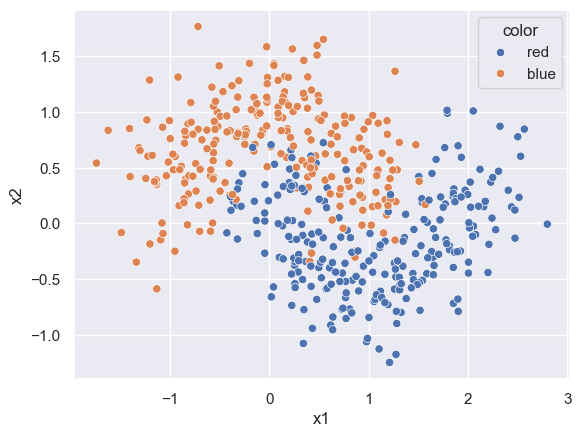

In [129]:
sns.set_theme()
sns.color_palette("Set2")
sns.scatterplot(data = moons, x="x1", y="x2", hue = "color")


In [130]:
moon_train, moon_test = moons.iloc[:375], moons.iloc[375:]
moon_train

,x1,x2,category,color
0,1.538699,0.188744,1,red
1,0.394699,0.323724,0,blue
2,-0.919147,1.311882,0,blue
3,1.053964,-0.700408,1,red
4,1.040678,-0.437339,1,red
...,...,...,...,...
370,0.435785,-0.186108,1,red
371,-0.565615,0.563578,0,blue
372,-1.205374,1.285517,0,blue
373,0.515727,-0.347822,1,red


In [131]:
moon_test

,x1,x2,category,color
375,0.501693,0.217172,1,red
376,0.227405,0.589937,1,red
377,0.268167,0.431114,1,red
378,1.312708,-0.595236,1,red
379,0.418356,-0.382677,1,red
...,...,...,...,...
495,1.163768,-0.710319,1,red
496,0.477238,-0.681340,1,red
497,-0.246390,0.709156,0,blue
498,0.897480,0.382935,0,blue


In [132]:

X_train = moon_train.iloc[:, :2].copy()
y_train = moon_train.iloc[:, 2].copy()

X_test = moon_test.iloc[:, :2].copy()
y_test = moon_test.iloc[:, 2].copy()


The data is largely balanced with the ratio being 0.344 instead of 0.333

In [133]:
moon_train["category"].sum(), moon_test["category"].sum()

(186, 64)

AdaBoost

In [134]:
from sklearn.tree import DecisionTreeClassifier

import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)


class Classifier():
    classifier = None
    sample_weights = None
    error_weight = None
    classifier_weight = None
    learning_weight = 1
    X = None
    y = None
    y_pred = None

    def __init__(self, X, y, sample_weights, learning_rate=1):
        self.sample_weights = sample_weights
        self.learning_weight = learning_rate
        self.classifier = DecisionTreeClassifier(max_depth=1, random_state=42)
        self.X = X
        self.y = y

        self.classifier.fit(
            X, y, sample_weight=np.array(sample_weights).ravel())

    def calc_error(self):
        self.y_pred = self.classifier.predict(self.X)
        misclassified = self.sample_weights[self.y_pred != self.y]

        self.error_weight = misclassified.sum() / self.sample_weights.sum()

        return self.error_weight

    def calc_classifier_weight(self):
        self.calc_error()
        self.classifier_weight = (
            self.learning_weight * np.log((1-self.error_weight) / self.error_weight)).item()

        return self.classifier_weight

    def get_classifier_weight(self):
        return self.classifier_weight

    def get_new_sample_weights(self):
        self.calc_classifier_weight()

        current_weights = np.array(self.sample_weights)
        new_weights = np.empty(len(self.y_pred))
        pos_factor = np.exp(self.classifier_weight)
        neg_factor = np.exp(-self.classifier_weight)

        for i in range(len(self.y_pred)):
            if self.y_pred[i] != self.y[i]:
                new_weights[i] = current_weights[i] * pos_factor
            else:
                new_weights[i] = current_weights[i]

        # Normalizing the weights
        new_weights = new_weights / np.sum(new_weights)
        return new_weights

    def predict(self, X):
        return self.classifier.predict(X).item()


In [135]:
class AdaBoost():

    n_estimators = None
    classifiers = None
    X = None
    y = None
    learning_rate = 1

    def __init__(self, X, y, n_estimators=1, learning_rate=1):
        self.n_estimators = n_estimators
        self.classifiers = [None] * n_estimators
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.weights = None
        self.error_rates = None

    def fit(self):
        # Initializes the weights for all samples to 1/N, where N is the number of data points
        init_sample_weights = np.array(len(self.X) * [1/len(self.X)])
        self.classifiers[0] = Classifier(self.X, self.y, init_sample_weights)
        self.classifiers[0].calc_classifier_weight()

        for i in range(1, self.n_estimators):
            self.classifiers[i] = Classifier(
                self.X, self.y, self.classifiers[i-1].get_new_sample_weights())

        self.classifiers[-1].calc_classifier_weight()

        self.weights = np.array(
            [clf.classifier_weight for clf in self.classifiers])

        self.error_rates = np.array(
            [clf.error_weight for clf in self.classifiers])

    def predict_sample(self, X, start, stop, past_predictions=None):
        voting_clfs = self.classifiers[start:stop]
        weight = self.weights[start:stop]
        # Calculate classifier weights for all classifiers at once

        # Predictions for all classifiers at once
        predictions = np.array([clf.predict(X) for clf in voting_clfs])

        # Count votes for class 1 and class 0
        vote_1 = np.sum(weight * (predictions == 1))
        vote_0 = np.sum(weight * (predictions == 0))

        if vote_1 > vote_0:
            return 1
        else:
            return 0

    def predict(self, X, clf_start=0, clf_stop=3000, past_predictions=None):
        # Predicts with the full ensemble of n_estimators number of models
        stop = self.n_estimators

        if clf_stop < stop:
            stop = clf_stop

        predictions = np.empty(len(X), dtype=np.int8)

        for i in range(len(X)):
            predictions[i] = self.predict_sample(
                X.iloc[[i]], clf_start, stop, past_predictions)

        return predictions

    def predict_ensembles(self, X):
        # X = X_input.to_numpy()
        
        predictions = np.empty((self.n_estimators, len(X)))
        
        voting_predictions = np.empty((len(X), self.n_estimators))
        
        
        for sample_row in range(len(X)):
            for clf in range(self.n_estimators):
                voting_predictions[sample_row][clf]  = self.classifiers[clf].predict(X.iloc[[sample_row]])
         
        
        print("Initial investment finished.")
         
        for k in range(self.n_estimators):
            for sample in range(len(X)):
    
                # Count votes for class 1 and class 0
                vote_1 = np.dot(self.weights[:k], (voting_predictions[sample][:k] == 1))
                vote_0 = np.dot(self.weights[:k],  (voting_predictions[sample][:k] == 0))

                if vote_1 > vote_0:
                    predictions[k][sample] = 1
                else:
                    predictions[k][sample] =0

            print(f"{k} Estimator finished.")
                
        return predictions

In [136]:

estimators = 3000
ada = AdaBoost(X_train, y_train, n_estimators= estimators)

ada.fit()
print("Done fitting")

Done fitting


Using AdaBoost implementation to get predictions on the Training and Testing datasets

In [137]:
y_pred_test = ada.predict_ensembles(X_test)

Initial investment finished.
0 Estimator finished.
1 Estimator finished.
2 Estimator finished.
3 Estimator finished.
4 Estimator finished.
5 Estimator finished.
6 Estimator finished.
7 Estimator finished.
8 Estimator finished.
9 Estimator finished.
10 Estimator finished.
11 Estimator finished.
12 Estimator finished.
13 Estimator finished.
14 Estimator finished.
15 Estimator finished.
16 Estimator finished.
17 Estimator finished.
18 Estimator finished.
19 Estimator finished.
20 Estimator finished.
21 Estimator finished.
22 Estimator finished.
23 Estimator finished.
24 Estimator finished.
25 Estimator finished.
26 Estimator finished.
27 Estimator finished.
28 Estimator finished.
29 Estimator finished.
30 Estimator finished.
31 Estimator finished.
32 Estimator finished.
33 Estimator finished.
34 Estimator finished.
35 Estimator finished.
36 Estimator finished.
37 Estimator finished.
38 Estimator finished.
39 Estimator finished.
40 Estimator finished.
41 Estimator finished.
42 Estimator fi

In [138]:
y_pred_train = ada.predict_ensembles(X_train)

Initial investment finished.
0 Estimator finished.
1 Estimator finished.
2 Estimator finished.
3 Estimator finished.
4 Estimator finished.
5 Estimator finished.
6 Estimator finished.
7 Estimator finished.
8 Estimator finished.
9 Estimator finished.
10 Estimator finished.
11 Estimator finished.
12 Estimator finished.
13 Estimator finished.
14 Estimator finished.
15 Estimator finished.
16 Estimator finished.
17 Estimator finished.
18 Estimator finished.
19 Estimator finished.
20 Estimator finished.
21 Estimator finished.
22 Estimator finished.
23 Estimator finished.
24 Estimator finished.
25 Estimator finished.
26 Estimator finished.
27 Estimator finished.
28 Estimator finished.
29 Estimator finished.
30 Estimator finished.
31 Estimator finished.
32 Estimator finished.
33 Estimator finished.
34 Estimator finished.
35 Estimator finished.
36 Estimator finished.
37 Estimator finished.
38 Estimator finished.
39 Estimator finished.
40 Estimator finished.
41 Estimator finished.
42 Estimator fi

In [139]:
y_true_test = np.array(y_test)
y_true_train = np.array(y_train)

Getting Accuracy Scores

In [140]:
from sklearn.metrics import accuracy_score

def get_accuracy(y_true, y_predictions, stop):
    scores = np.empty(stop)

    for i in range(stop):
        scores[i] = 1 - accuracy_score(y_true, y_predictions[i])
        score_df = pd.DataFrame(scores)
        score_df.to_csv("scores.csv")

    return scores


test_scores = get_accuracy(y_true_test, y_pred_test, estimators)
train_scores = get_accuracy(y_true_train, y_pred_train, estimators)

Text(0.5, 1.0, 'Prediction Error after 3000 Iterations')

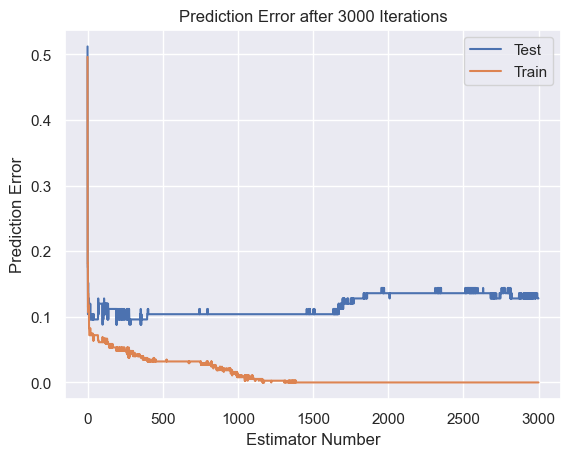

In [141]:
x = np.arange(3000)

sns.lineplot(x = x, y = test_scores, label = "Test")
sns.lineplot(x = x, y = train_scores, label = "Train")
plt.xlabel("Estimator Number")
plt.ylabel("Prediction Error")
plt.title("Prediction Error after 3000 Iterations")

Text(0.5, 1.0, 'Prediction Error after 200 Iterations')

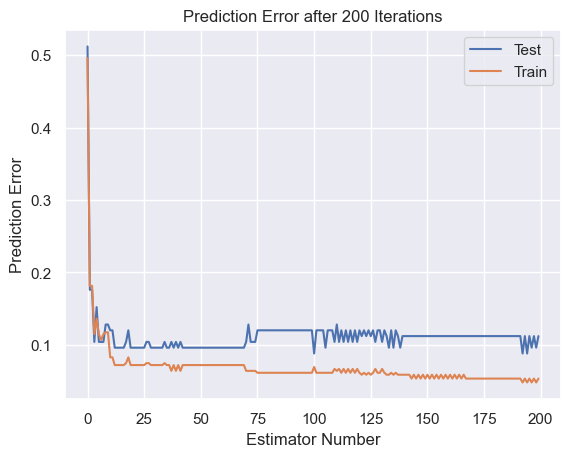

In [142]:
x = np.arange(200)

sns.lineplot(x = x, y = test_scores[:200], label = "Test")
sns.lineplot(x = x, y = train_scores[:200], label = "Train")
plt.xlabel("Estimator Number")
plt.ylabel("Prediction Error")
plt.title("Prediction Error after 200 Iterations")

Observation: The model is able to reduce its training prediction error as the number of estimators increases; however this is at the cost of performance on the test data. This is a strong indicator of overfitting to the training dataset.

Text(0.5, 1.0, 'Classifier Weights across 3000 Iterations')

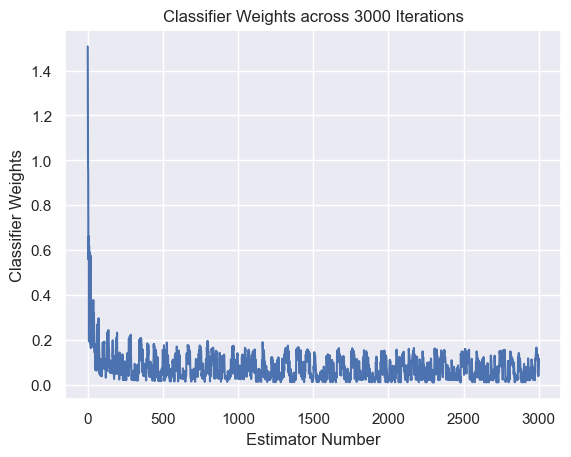

In [143]:
x = np.arange(3000)

sns.lineplot(x = x, y = ada.weights)
plt.xlabel("Estimator Number")
plt.ylabel("Classifier Weights")
plt.title("Classifier Weights across 3000 Iterations")

Text(0.5, 1.0, 'Weighted Error Rates across 3000 Iterations')

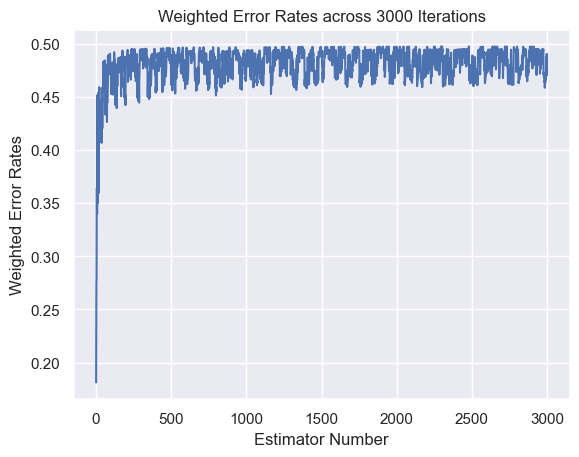

In [150]:
x = np.arange(3000)

sns.lineplot(x = x, y = ada.error_rates)
plt.xlabel("Estimator Number")
plt.ylabel("Weighted Error Rates")
plt.title("Weighted Error Rates across 3000 Iterations")

In [1]:
x = np.arange(3000)
scores = 1- train_scores

sns.lineplot(x = x, y = scores)
plt.xlabel("Estimator Number")
plt.ylabel("Accuracy")
plt.title("Accuracy after 3000 Iterations")

NameError: name 'np' is not defined

Text(0.5, 1.0, 'Accuracy after 200 Iterations')

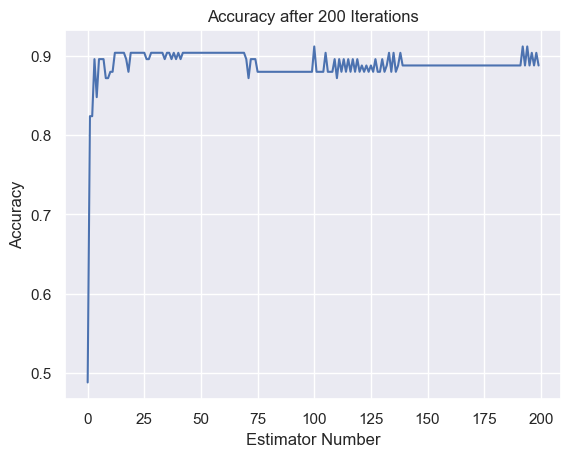

In [153]:
x = np.arange(200)

sns.lineplot(x = x, y = scores[:200])
plt.xlabel("Estimator Number")
plt.ylabel("Accuracy")
plt.title("Accuracy after 200 Iterations")

Plotting Decision Boundaries

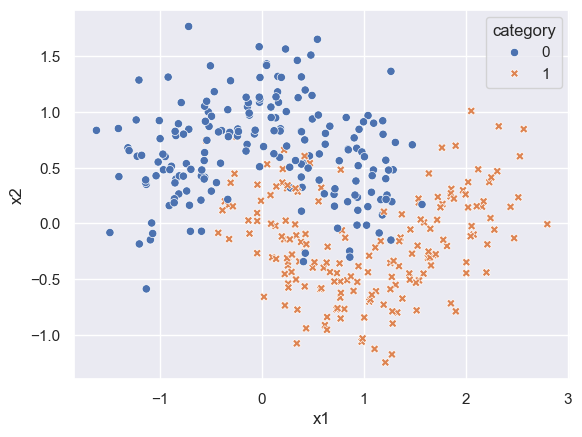

In [211]:
sns.scatterplot(data = moon_train, x = "x1", y= "x2", hue = "category", style = "category")
y_min, y_max = plt.gca().get_ylim()
x_min, x_max = plt.gca().get_xlim()

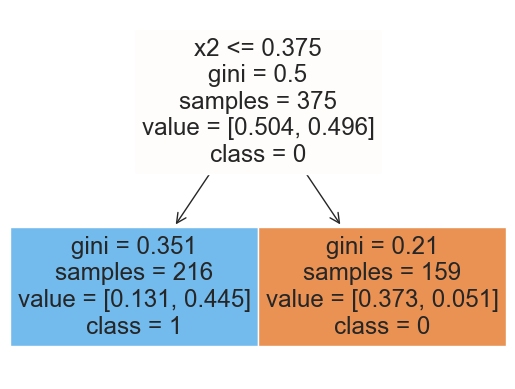

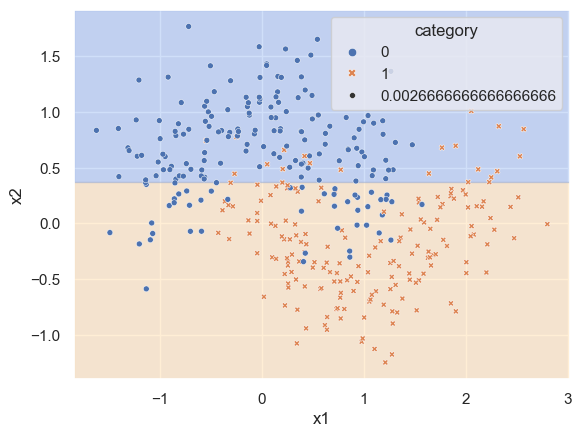

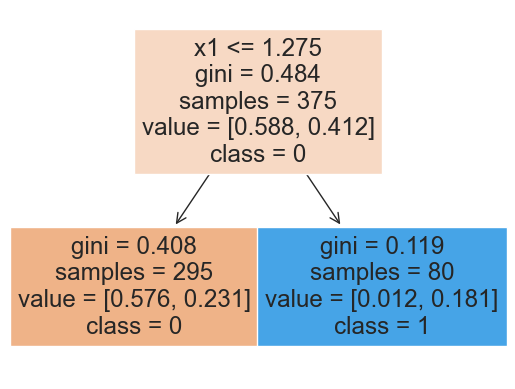

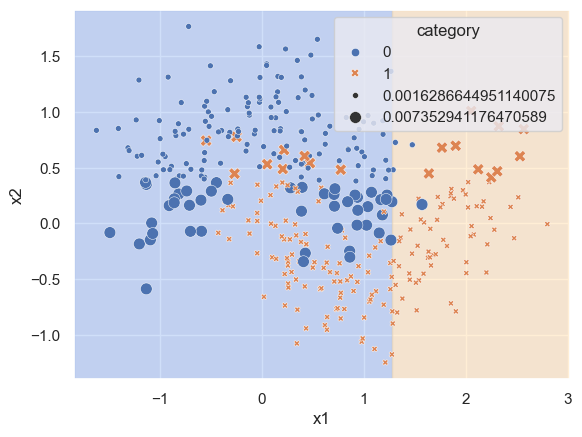

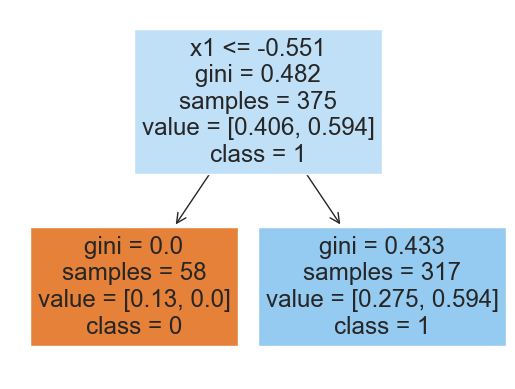

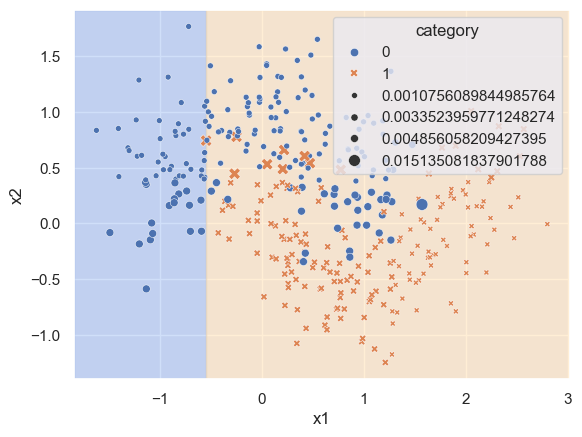

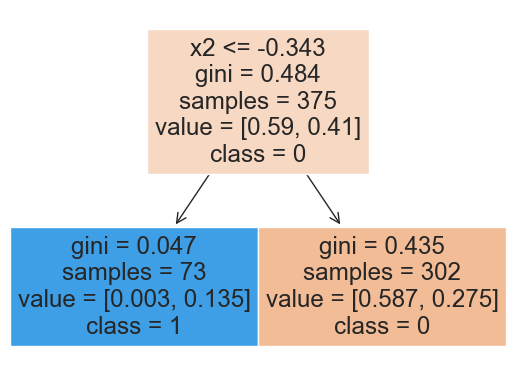

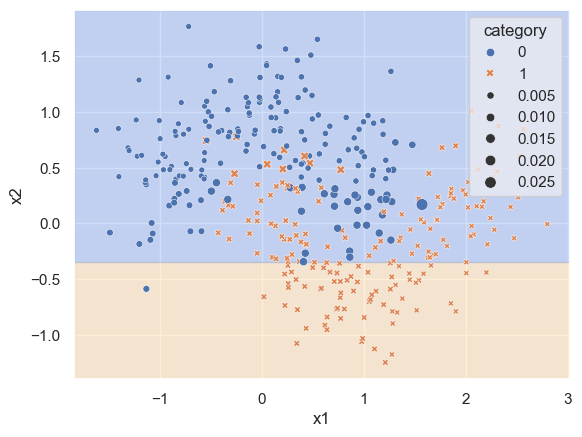

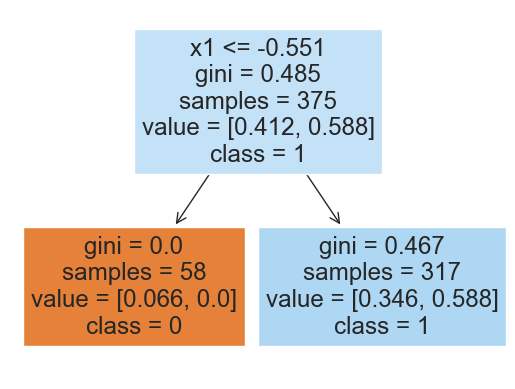

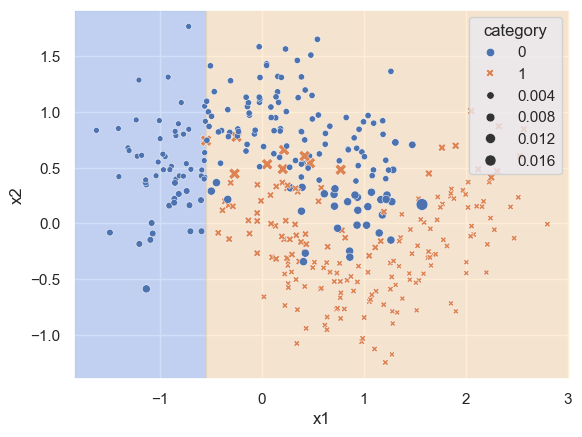

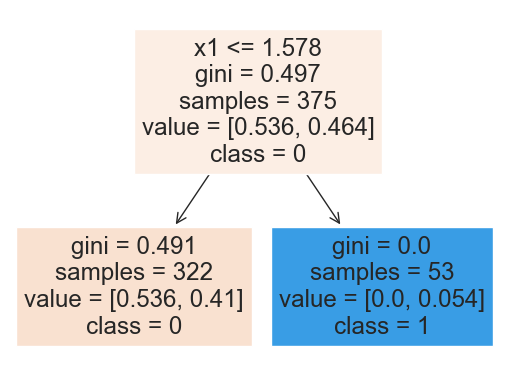

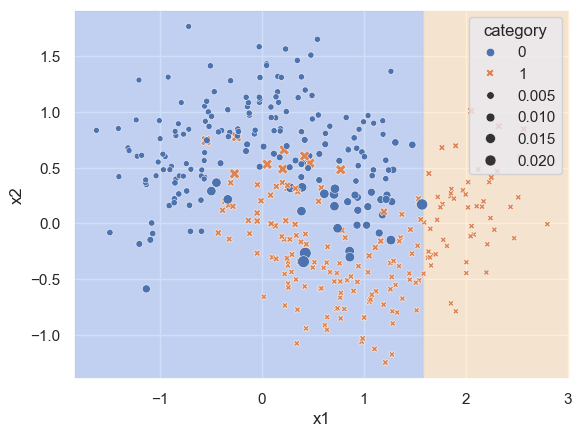

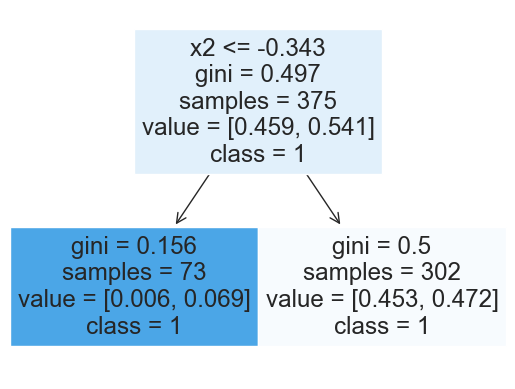

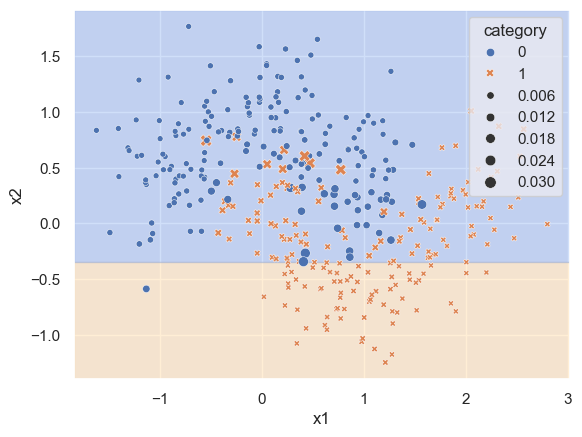

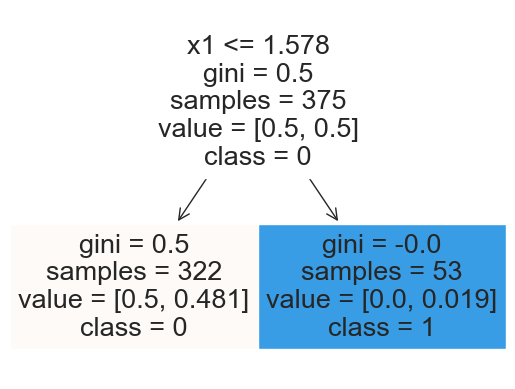

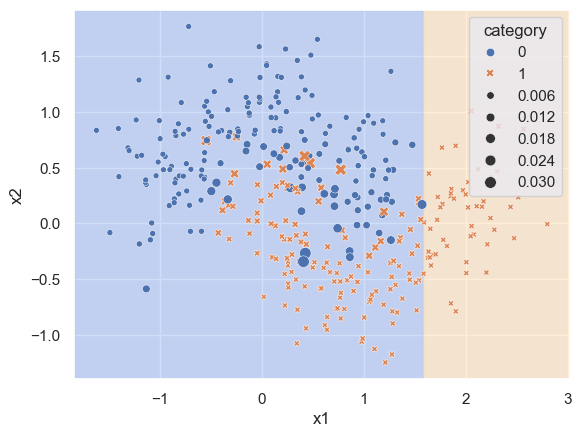

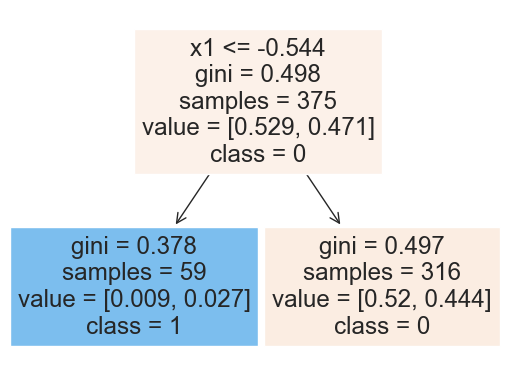

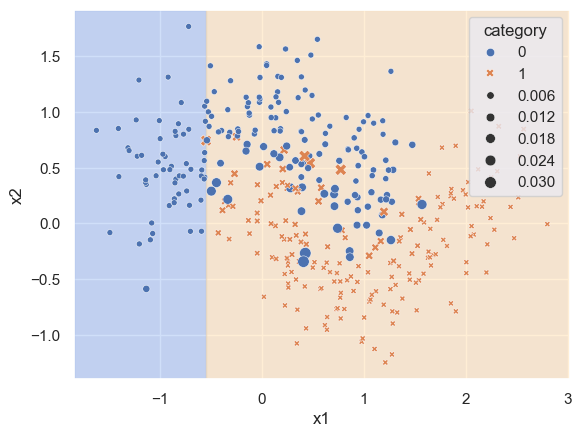

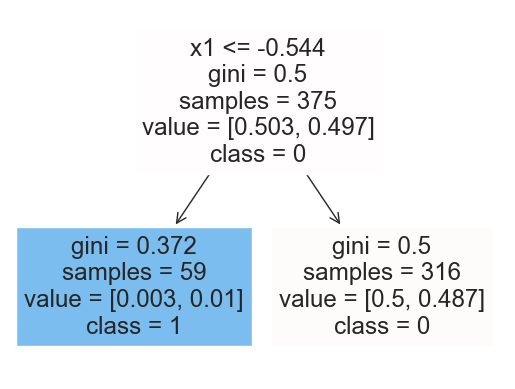

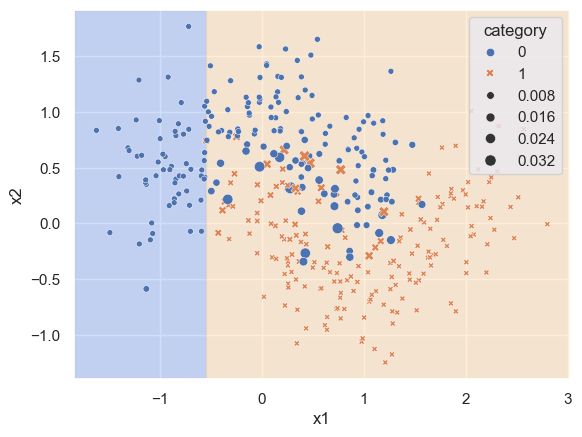

In [228]:
from sklearn.tree import plot_tree

indices = [0, 1, 2, 3, 4, 14, 20, 50, 100, 1000]

for index in indices:
    plt.clf()
    plot_tree(ada.classifiers[index].classifier, filled = True, feature_names= ["x1", "x2"], class_names = ["0", "1"])
    plt.show()

    plt.clf()
    threshold = ada.classifiers[index].classifier.tree_.threshold[0]
    feature = ada.classifiers[index].classifier.tree_.feature[0]
    weight = ada.classifiers[index].sample_weights
    if feature == 1:
        plt.axhspan(ymin= y_min, ymax = threshold, color = "navajowhite", alpha = 0.5)
        plt.axhspan(ymin= threshold, ymax = y_max, color = "cornflowerblue", alpha = 0.3)
    else:
        plt.axvspan(xmin = x_min, xmax = threshold, color = "cornflowerblue", alpha = 0.3)
        plt.axvspan(xmin= threshold, xmax = x_max, color = "navajowhite", alpha = 0.5)
          
    sns.scatterplot(data = moon_train, x = "x1", y= "x2", hue = "category", style = "category", size = weight)
    plt.gca().set_xlim(x_min, x_max)
    plt.gca().set_ylim(y_min, y_max)
    plt.show()


Decision boundaries for ensemble models can be graphed by going through the decision trees with plot_tree and sequentially overlaying them over each other. In theory, this should give the boundary. In practice, this may not work.